In [1]:
from graph_ds import PyH3Graph
from pois_to_h3 import get_pois_h3
import pandas as pd
import h3.api.numpy_int as h3
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [13]:
def plot_hex_df(df, markersize, color_column=None, color_categorical=False):
    df[['y','x']] = list(df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    fig, ax = plt.subplots(figsize=(10,10))
    # Show the GeoPandas DataFrame

    if color_column:
        gdf.plot(ax=ax, column=color_column, categorical=color_categorical, legend=True, markersize=markersize, alpha=0.5, cmap='Reds')
    else:
        gdf.plot(ax=ax, markersize=markersize, alpha=0.5)

    #plt.xlim(12.391681,12.737388)
    #plt.ylim(55.549206, 55.759991)

    cx.add_basemap(ax = ax, crs="EPSG:4326")
    #plt.show()

In [5]:
graph = PyH3Graph(bike_penalty=1, k_ring=2)
graph.create(osm_path="../resources/copenhagen-processed.osm.pbf", gtfs_path="../resources/rejseplanen_GTFS.zip")

processing osm pbf file: ../resources/copenhagen-processed.osm.pbf
converted OSM file into 490098 edges
osm graph created with (418149) nodes (walk + bike) in 17 s
getting GTFS feed from ../resources/rejseplanen_GTFS.zip
routes: 1690
gtfs graph created with 104882 nodes in 47 s
merged graph created with 520907 nodes in 0 s
hash: 5353382925555178049


# Get Origins

In [6]:
from ghsl_processing import crop_tif_image, reproject_tif, tif_to_h3
# Open the raster file
tif_path= '../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19.tif'
cropped_tif_file = '../resources/copenhagen_subset.tif'

# paste csv bounding box from this website https://boundingbox.klokantech.com/ 
bbox = [12.3999, 55.6059, 12.7456, 55.7652] # [xmin, ymin, xmax, ymax]

# CROP
# cropping crs from latlon --> tif crs
src_crs = 'EPSG:4326'
dst_crs = 'ESRI:54009'
crop_tif_image(tif_path, cropped_tif_file, bbox, src_crs, dst_crs)

# Reproj
# reprojection goes from tif crs --> latlon 
src_crs = 'ESRI:54009'
dst_crs = 'EPSG:4326'
reprojected_file = '../resources/reprojected_copenhagen.tif'
transformation = reproject_tif(cropped_tif_file, dst_crs, reprojected_file)

H3_RES = 12
h3_csv = '../resources/ghsl_h3_codes.csv'
tif_to_h3(reprojected_file, transformation, h3_csv, H3_RES)

origins = pd.read_csv(h3_csv)

# Get Destinations

In [7]:
pbf_path = "../resources/copenhagen-processed.osm.pbf"

# idea: EVERYONE can use it and live a healthy life with this as their only source
#check: doctors, clinic, health_food, food
#essential filter will be the least restrictive!

# frequency arguments - how often do you use these?
# no workplace - motivate this... unrealistic to get data, and for people to work within 15 minutes of their homes
essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors","school"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park"], "sport":True
    }

# parameters

H3_RES = 12

# n minute city must satisfy the following expression based on
# the existence of certain tags within n minutes:
category_set = set(['pharmacy','park','supermarket','sport', 'school'])

# easy use case which is debateably also essential
#education_filter = {"amenity":["school"]}

osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport'
}

h3_df = get_pois_h3(pbf_path, essential_filter, H3_RES, category_set, osm_tag_mapping)

/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/petermehler/opt/anaconda3/envs/graphs/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


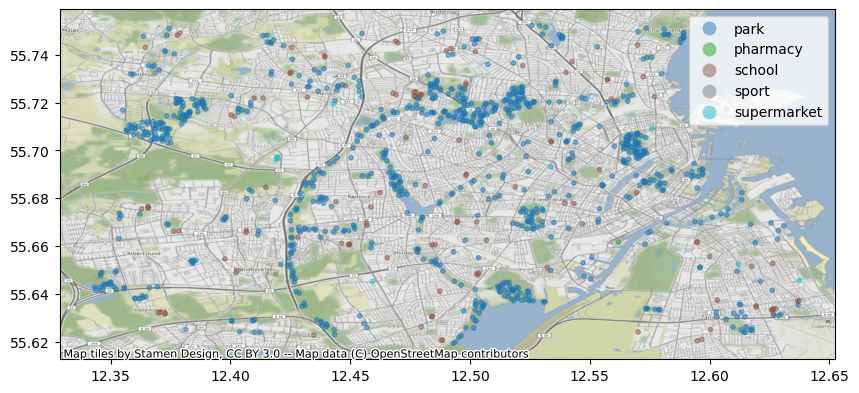

In [8]:
sample_df = h3_df.sample(1000) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
# geopandas.points_from_xy(x, y, z=None, crs=None)
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='category', categorical=True, legend=True, markersize=10, alpha=0.5)

# denmark
#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

# middle east
#plt.ylim(12.391681,12.737388)
#plt.xlim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_6937/680607083.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])


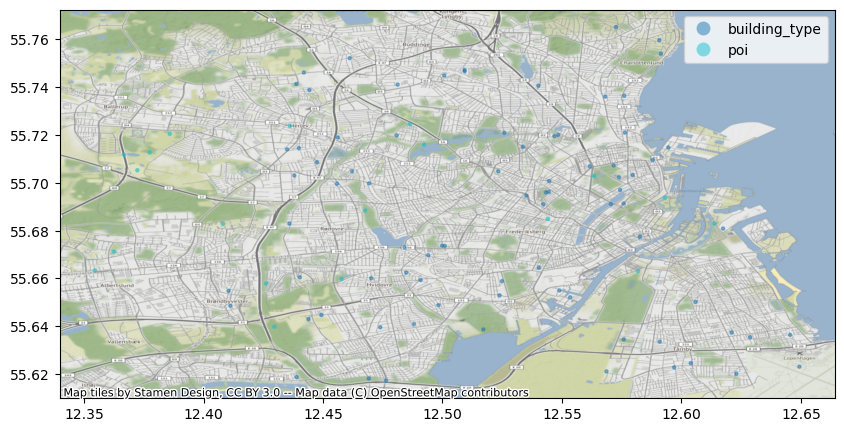

In [9]:
h3_df['hex_type'] = 'poi'
origins = pd.read_csv(h3_csv)
origins = origins[origins['residential_bool']==1]
origins['hex_type'] = 'building_type'
combined = origins[['h3_index','hex_type']].append(h3_df[['h3_index','hex_type']])

sample_df = combined.sample(100) #df.sample(100)
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='hex_type', categorical=True, legend=True, markersize=5, alpha=0.5)

#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

In [22]:
# for testing
category_set = set(['pharmacy','supermarket','sport', 'school'])

origins = pd.read_csv(h3_csv).sample(10)
origins = list(origins[origins['residential_bool']==1]['h3_index'])

category_travel_time_means = {}
for c in category_set:
    print(c)
    destinations = list(h3_df[h3_df['category']==c]['h3_index'])
    ds = graph.matrix_distance(origins=origins, destinations=destinations, hour_of_week = None)
    # they might be different lengths, so we can't use a df
    mins = {k:np.min(v) for k,v in ds.items()}
    print(len(mins))
    category_travel_time_means[c] = np.mean(list(mins.values()))
    break

supermarket
matrix distance computed for 8 origins - got 7 results
7


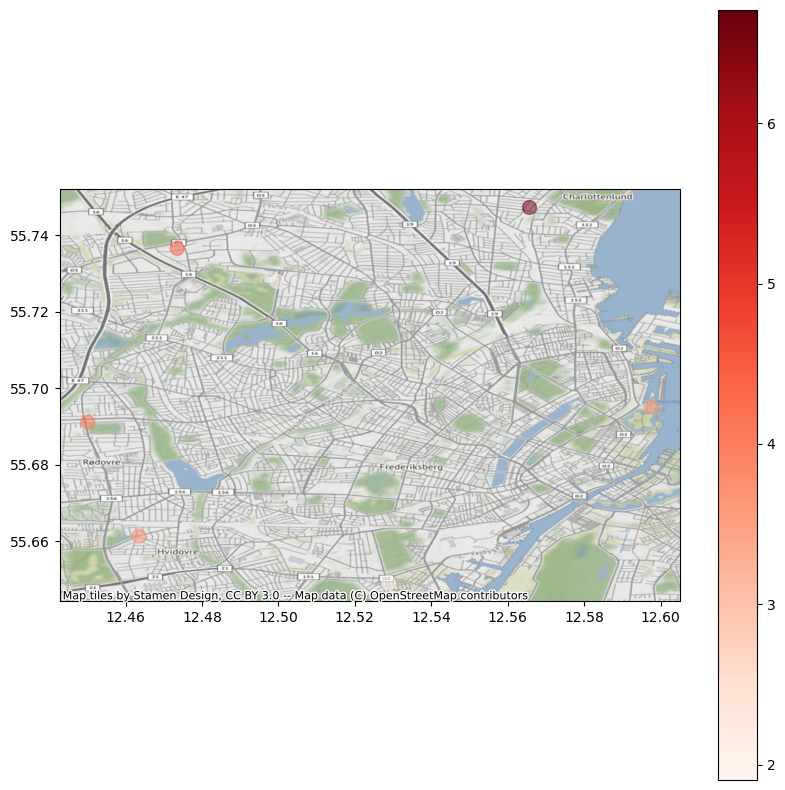

In [23]:
plot_df = pd.DataFrame([(k,v) for k,v in mins.items()], columns = ['h3_index','mean_dist'])
plot_hex_df(plot_df, markersize=100, color_column='mean_dist')

In [95]:
category_travel_time_means

{'pharmacy': 7.633791876874984,
 'supermarket': 7.308820343324985,
 'school': 4.707763105499996,
 'sport': 9.47953391982497}

In [38]:
sample_df = list(h3_df[h3_df['category']=='school']['h3_index'])

In [40]:
graph.matrix_distance(origins=[origins[0]], destinations=[sample_df[0]], hour_of_week = None)

{631049688288871423: [19.461068449499926]}

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_99781/2939849049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_99781/2939849049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))


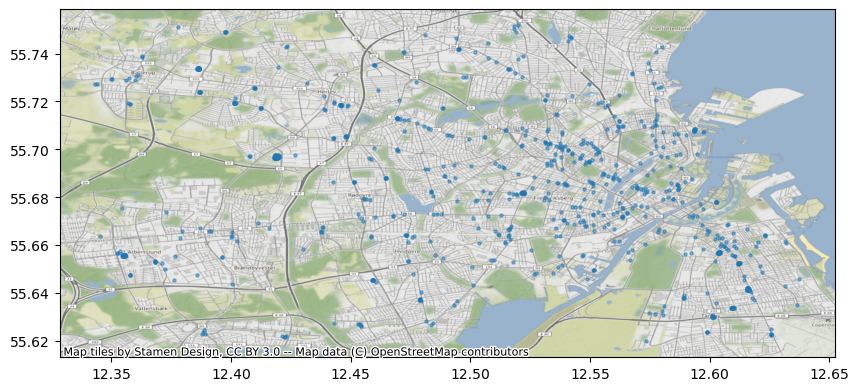

In [34]:
sample_df = h3_df[h3_df['category']=='supermarket']
sample_df[['y','x']] = list(sample_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=5, alpha=0.5)

#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

(array([ 4.,  5.,  8., 10., 20., 24., 30., 29., 23., 37., 38., 28., 32.,
        40., 22., 24., 40., 23., 30., 36., 21., 19., 20., 16., 16., 16.,
        20., 14., 19., 11., 10.,  8.,  7.,  0.,  4.,  3.,  4.,  2.,  3.,
         2.,  3.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.44835839,  0.77231871,  1.09627902,  1.42023933,  1.74419965,
         2.06815996,  2.39212028,  2.71608059,  3.04004091,  3.36400122,
         3.68796153,  4.01192185,  4.33588216,  4.65984248,  4.98380279,
         5.30776311,  5.63172342,  5.95568373,  6.27964405,  6.60360436,
         6.92756468,  7.25152499,  7.57548531,  7.89944562,  8.22340593,
         8.54736625,  8.87132656,  9.19528688,  9.51924719,  9.84320751,
        10.16716782, 10.49112813, 10.81508845, 11.13904876, 11.46300908,
        11.78696939, 12.11092971, 12.43489002, 12.75885033, 13.08281065,
        13.40677096, 13.73073128, 14.05469159, 14.37865191, 14.70261222,
        15.02657253, 15.35053285, 15.67449316, 15.99845348,

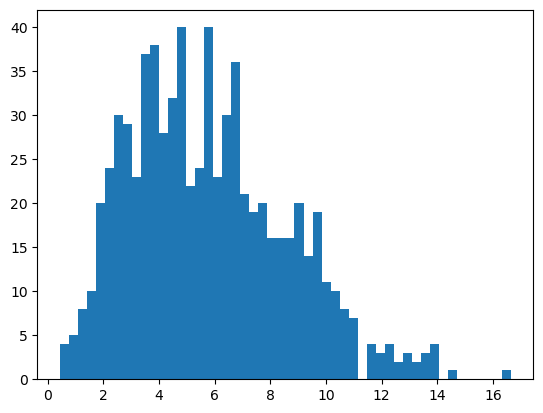

In [16]:
plt.hist(df.values, bins=50)

In [ ]:
df[['y','x']] = list(df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(sample_df, geometry=gpd.points_from_xy(sample_df.x, sample_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, column='hex_type', categorical=True, legend=True, markersize=5, alpha=0.5)

#plt.xlim(12.391681,12.737388)
#plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")

In [39]:
orgs = [int(x) for x in np.random.choice(origins,10)]
dests = [int(x) for x in np.random.choice(destinations,10)]

In [67]:
#for each origin for each poi type (run separately), make matrix of routing times

In [42]:
ds = graph.matrix_distance(origins=orgs, destinations=dests, hour_of_week = None)

thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:thread '<unnamed>' panicked at '41index out of bounds: the len is 0 but the index is 0
', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', graph-ds/src/lib.rs:480:41
thread '<unnamed>' panicked at 'index out of bounds: the len is 0 but the index is 0', g

PanicException: index out of bounds: the len is 0 but the index is 0

In [84]:
pd.DataFrame({'origin':[1,2,3],'origin2':[4,5,6]}).min(axis=0)

origin     1
origin2    4
dtype: int64

In [136]:
np.mean(list({k:np.min(v) for k,v in {'origin':[1,2,3],'origin2':[4,5,6]}.items()}.values()))

2.5

In [61]:
issue_inds = []
for i in range(len(destinations)):
    res = graph.matrix_distance(origins=[origins[0]], destinations=[destinations[i]], hour_of_week = None)
    if not res[origins[0]]:
        issue_inds.append(i)


In [65]:
for i in issue_inds:
    res = graph.matrix_distance(origins=[origins[0]], destinations=[origins[0],destinations[i]], hour_of_week = None)
    if not res[origins[0]]:
        print(i)

247
394
396


In [89]:
issue_df

,h3_index,y,x,geometry
0,631051737789436415,55.752507,12.347319,POINT (12.34732 55.75251)
1,631049684202690047,55.722502,12.569857,POINT (12.56986 55.72250)
2,631049684202697215,55.722255,12.569719,POINT (12.56972 55.72225)


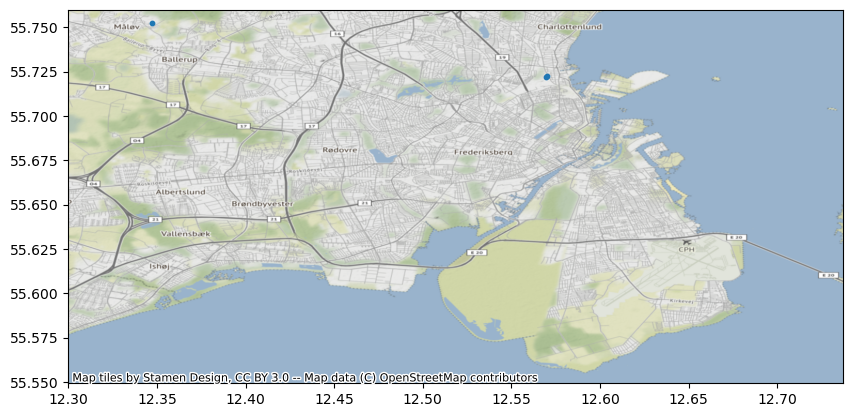

In [92]:
found_broken_schools = [247,394,396]

issue_df = pd.DataFrame([destinations[x] for x in found_broken_schools], columns=['h3_index'])
issue_df[['y','x']] = list(issue_df['h3_index'].apply(h3.h3_to_geo))
# Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
gdf = gpd.GeoDataFrame(issue_df, geometry=gpd.points_from_xy(issue_df.x, issue_df.y))

fig, ax = plt.subplots(figsize=(10,10))
# Show the GeoPandas DataFrame
gdf.plot(ax=ax, markersize=10, alpha=1)


#plt.xlim(12.55,12.60)
#plt.ylim(55.71, 55.759991)
plt.xlim(12.3,12.737388)
plt.ylim(55.549206, 55.759991)

cx.add_basemap(ax = ax, crs="EPSG:4326")